In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', as_frame=False)

In [3]:
X, y = mnist.data, mnist.target

In [4]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [5]:
X.shape

(70000, 784)

In [6]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [7]:
y.shape

(70000,)

In [10]:
import matplotlib.pyplot as plt

In [13]:
def plot_digit(image_data):
    image = image_data.reshape(28,28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

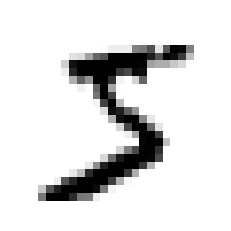

In [28]:
some_digit = X[0] 
plot_digit(some_digit)
plt.show()

In [17]:
y[0]

'5'

In [18]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a binary classifier
Starting simple, we will just look for the 5s in the dataset.

In [25]:
y_train_5 = (y_train=='5')
y_test_5 = (y_test=='5')

In [26]:
y_train_5[:5]

array([ True, False, False, False, False])

In [27]:
from sklearn.linear_model import SGDClassifier

sgdclf = SGDClassifier(random_state=42)
sgdclf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [30]:
sgdclf.predict([some_digit])

array([ True])

In [31]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgdclf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [32]:
from sklearn.dummy import DummyClassifier

dummyclf = DummyClassifier()
dummyclf.fit(X_train, y_train_5)
print(any(dummyclf.predict(X_train)))

False


In [33]:
cross_val_score(dummyclf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

In [37]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgdclf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_train_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_train_fold)
    print (n_correct / len(y_pred))

0.95035
0.96035
0.9604


In [38]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgdclf, X_train, y_train_5, cv=3)

In [39]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

In [40]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred) , recall_score(y_train_5, y_train_pred)

(0.8370879772350012, 0.6511713705958311)

In [41]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [45]:
y_scores = cross_val_predict(sgdclf, X_train, y_train_5, cv=3, method="decision_function")

In [47]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

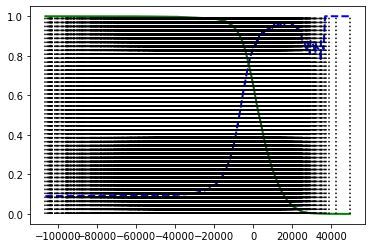

In [51]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(thresholds, 0, 1.0, "k", "dotted", label="Treshold")
plt.show()

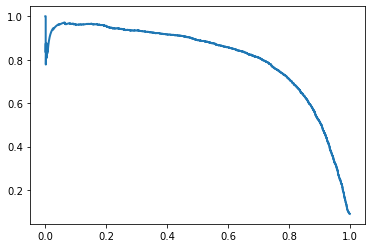

In [53]:
plt.plot(recalls, precisions, linewidth=2, label="Recall Precision Curve")
plt.show()

In [55]:
idx_for_90_precision = (precisions>0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.0194991439557

In [56]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [57]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [58]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706